In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Metrics & Selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# CẤU HÌNH HIỂN THỊ
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
DATA_DIR = "datasets/"
EARLY_DAYS = 14  # Chỉ dùng dữ liệu 2 tuần đầu
MODULE = "EEE"   # Bạn có thể đổi module khác hoặc bỏ lọc để lấy hết
PRESENTATION = "2014J"

print(f"🔄 Đang tải và xử lý dữ liệu (Cửa sổ thời gian: {EARLY_DAYS} ngày)...")

# Load Data
student_info = pd.read_csv(DATA_DIR + "studentInfo.csv")
student_vle = pd.read_csv(DATA_DIR + "studentVle.csv")
vle = pd.read_csv(DATA_DIR + "vle.csv")
student_reg = pd.read_csv(DATA_DIR + "studentRegistration.csv")

# 1.1 Tạo biến mục tiêu (Target)
target_students = student_info[
    (student_info["code_module"] == MODULE) & 
    (student_info["code_presentation"] == PRESENTATION)
].copy()
target_students["is_dropout"] = np.where(target_students["final_result"] == "Withdrawn", 1, 0)

# 1.2 Phân tích hành vi chi tiết (Clickstream)
vle_merged = student_vle.merge(vle[['id_site', 'activity_type']], on='id_site', how='left')
early_logs = vle_merged[
    (vle_merged['code_module'] == MODULE) & 
    (vle_merged['code_presentation'] == PRESENTATION) & 
    (vle_merged['date'] <= EARLY_DAYS)
]

# Pivot: Tách các loại click ra thành cột riêng
click_features = early_logs.pivot_table(
    index='id_student', columns='activity_type', values='sum_click', aggfunc='sum', fill_value=0
)
click_features.columns = [f"clicks_{col}" for col in click_features.columns] # Rename columns
click_features['total_clicks'] = click_features.sum(axis=1)

# 1.3 Tính Trend (Xu hướng tuần 2 so với tuần 1)
w1 = early_logs[early_logs['date'] <= 7].groupby('id_student')['sum_click'].sum()
w2 = early_logs[early_logs['date'] > 7].groupby('id_student')['sum_click'].sum()
trend_df = pd.DataFrame({'w1': w1, 'w2': w2}).fillna(0)
trend_df['trend_score'] = trend_df['w2'] - trend_df['w1']

# 1.4 Thông tin đăng ký (Registration Lag)
reg_info = student_reg[
    (student_reg["code_module"] == MODULE) & 
    (student_reg["code_presentation"] == PRESENTATION)
][['id_student', 'date_registration']]

# 1.5 Gộp tất cả lại (Merge)
df_final = target_students[['id_student', 'gender', 'highest_education', 'num_of_prev_attempts', 'studied_credits', 'is_dropout']]
df_final = df_final.merge(click_features, on='id_student', how='left')
df_final = df_final.merge(trend_df[['trend_score']], on='id_student', how='left')
df_final = df_final.merge(reg_info, on='id_student', how='left')
df_final = df_final.fillna(0) # Điền 0 cho data bị thiếu

🔄 Đang tải và xử lý dữ liệu (Cửa sổ thời gian: 14 ngày)...


In [4]:
numeric_features = [col for col in df_final.columns if 'clicks_' in col] + \
                   ['num_of_prev_attempts', 'studied_credits', 'trend_score', 'total_clicks', 'date_registration']
categorical_features = ['gender', 'highest_education']

X = df_final[numeric_features + categorical_features]
y = df_final['is_dropout']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"✅ Dữ liệu sẵn sàng. Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

✅ Dữ liệu sẵn sàng. Train size: 831, Test size: 357


In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

results = []
trained_pipelines = {}

print("\n🚀 Bắt đầu huấn luyện và so sánh 4 Models...")


🚀 Bắt đầu huấn luyện và so sánh 4 Models...


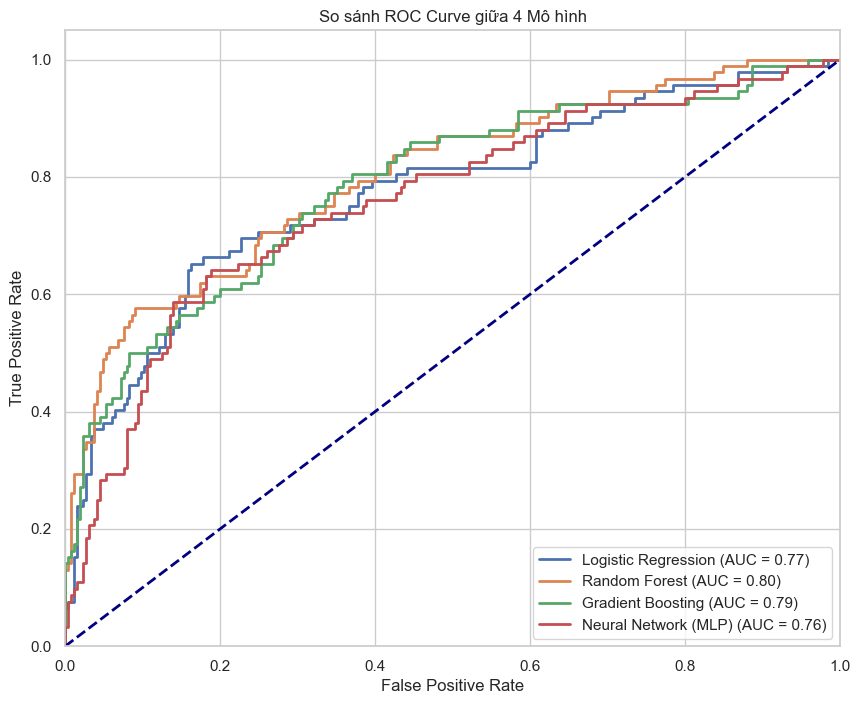

In [6]:
plt.figure(figsize=(10, 8)) # Chuẩn bị vẽ ROC Curve gộp

for name, model in models.items():
    start_time = time.time()
    
    # Tạo Pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Train
    clf.fit(X_train, y_train)
    trained_pipelines[name] = clf
    
    # Predict (Sử dụng xác suất để chỉnh threshold nếu cần)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    # Chọn ngưỡng 0.4 (thấp hơn 0.5 để ưu tiên bắt Dropout)
    THRESHOLD = 0.4
    y_pred = (y_pred_proba >= THRESHOLD).astype(int)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Lưu kết quả
    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Recall (Dropout)": recall,
        "AUC": roc_auc,
        "Time": time.time() - start_time
    })
    
    # Vẽ đường ROC cho model này
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Hoàn thiện biểu đồ ROC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('So sánh ROC Curve giữa 4 Mô hình')
plt.legend(loc="lower right")
plt.show()


=== BẢNG TỔNG HỢP KẾT QUẢ ===
                  Model  Accuracy  F1-Score  Recall (Dropout)       AUC  \
1         Random Forest  0.792717  0.588889          0.576087  0.802871   
2     Gradient Boosting  0.798319  0.560976          0.500000  0.785480   
3  Neural Network (MLP)  0.784314  0.538922          0.489130  0.759270   
0   Logistic Regression  0.630252  0.528571          0.804348  0.774159   

       Time  
1  0.225888  
2  0.475984  
3  5.377812  
0  0.134487  


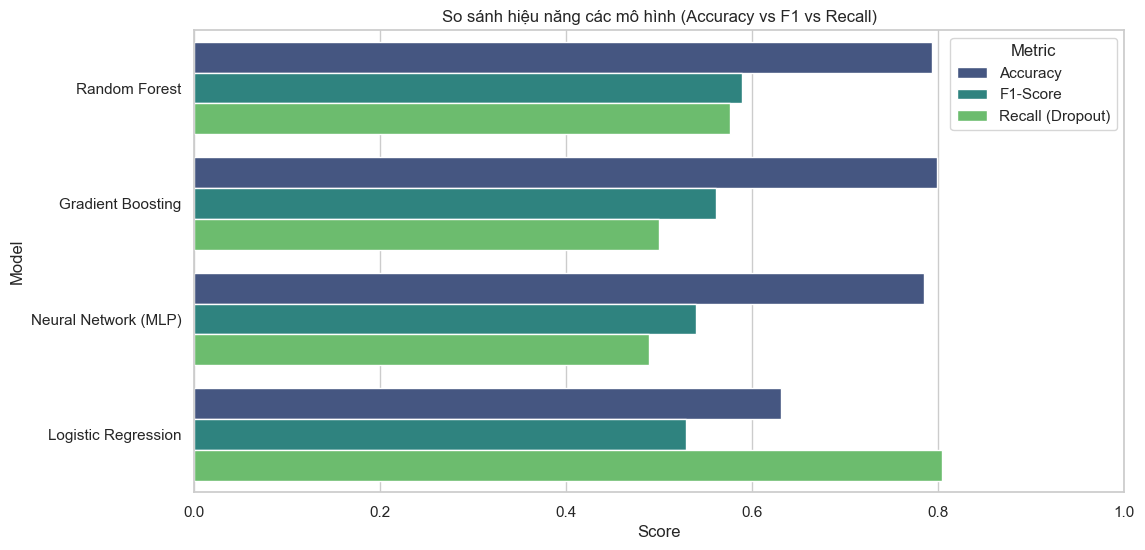

In [7]:
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("\n=== BẢNG TỔNG HỢP KẾT QUẢ ===")
print(results_df)

# Vẽ biểu đồ so sánh Metric
results_melted = results_df.melt(id_vars="Model", value_vars=["Accuracy", "F1-Score", "Recall (Dropout)"], var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(x="Score", y="Model", hue="Metric", data=results_melted, palette="viridis")
plt.title("So sánh hiệu năng các mô hình (Accuracy vs F1 vs Recall)")
plt.xlim(0, 1)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10612\2731491032.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='magma')


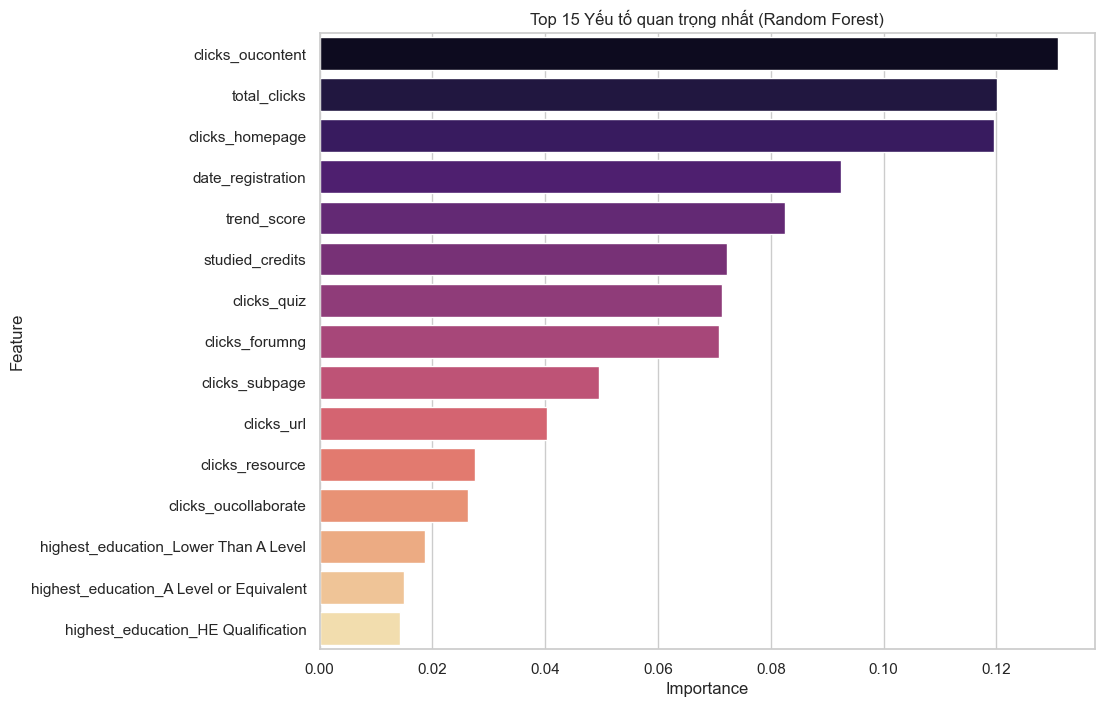

In [8]:
rf_pipeline = trained_pipelines["Random Forest"]
rf_model = rf_pipeline.named_steps['classifier']
preprocessor_step = rf_pipeline.named_steps['preprocessor']

# Lấy tên features
cat_features_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_features_names)
importances = rf_model.feature_importances_

# Vẽ
fi_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='magma')
plt.title('Top 15 Yếu tố quan trọng nhất (Random Forest)')
plt.show()